# Discovering Themes
### Uncovering Latent Topics in Fitzgerald’s Novels with NLP

This notebook explores recurring themes in F. Scott Fitzgerald’s novels using topic modeling. By applying unsupervised learning methods like Latent Dirichlet Allocation (LDA) and BERTopic, it looks for underlying patterns and semantic structures in the text. The aim is to highlight dominant themes and track how they change across chapters or different works.

## Import libraries

In [1]:
%run ../notebooks/setup_path.py
from config import *

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict
import re

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Topic Modeling
from gensim.models.phrases import Phrases, Phraser
import gensim.corpora as corpora
from gensim.models import TfidfModel, LdaModel, LdaMulticore, CoherenceModel

# Utilities
from pprint import pprint
from collections import Counter
import pandas as pd
import json
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Text Processing

This part of the project focuses on preparing the cleaned, sentence-tokenized texts for topic modeling. Since the texts are already split into sentences, the next step is to apply word tokenization, part-of-speech tagging, and lemmatization at the sentence level. This helps normalize words to their base forms while keeping their grammatical context, which improves the clarity and relevance of the topics. Once each sentence is processed, the lemmatized tokens are grouped back by chapters based on previously identified chapter boundaries. This method preserves the thematic flow within chapters, allowing topic modeling to capture how themes shift and develop throughout each novel.

- **Stopwords**

Standard English stopwords are loaded and expanded with custom stopwords, including frequent character names and locations from the novels. This helps prevent these terms from dominating the topic modeling results.

In [2]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [3]:
custom_stopwords = [
    # Character Names
    "amory", "blaine", "isabelle", "borgé", "rosalind", "connage", "eleanor", "savage", "beatrice", "monsignor",
    "darcy", "thayer", "burne", "anthony", "patch", "gloria", "gilbert", "caramel", "dick", "richard",
    "maury", "noble", "joseph", "bloeckman", "muriel", "nick", "carraway", "gatsby", "jay", "james",
    "gatz", "daisy", "tom", "buchanan", "jordan", "baker", "myrtle", "george", "wilson", "owl",
    "eyes", "klipspringer", "wolfsheim", "meyer", "dan", "cody", "henry", "catherine", "pammy", "mckee",
    "michaelis", "alec", "old", "sport", "sally", "marietta", "wolfshiem", "adam", "barbara", "rachael",
    "kane",

    # Places
    "princeton", "minneapolis", "atlantic", "new", "york", "harvard", "broadway", "west", "egg", "east",
    "valley", "ashes", "fifth", "avenue", "long", "island", "midwest", "chicago", "garage", "pennsylvania",

    # Social Titles and Misc. Proper Nouns
    "baedeker", "captain", "charles", "clara", "ella", "eckleburg", "eyebrow", "granny", "janitor", "john",
    "kerry", "mary", "miss", "mister", "mr", "mrs", "robert", "sloane", "thomas", "william",
    "regis", "geraldine", "paramore", "grandfather", "officer", "rose"
]

stop_words = stop_words.union(custom_stopwords)

Additional words are added to the stopword list after the initial model run. These come from reviewing the most frequent words and top topic words that didn’t describe the themes but were part of the narrative, ensuring the model focuses on meaningful topics.

In [4]:
additional_stopwords = [
    # Generic Verbs
    "asked", "became", "called", "came", "come", "cried", "decided", "dozen", "feel", "find",
    "found", "get", "give", "go", "going", "got", "gone", "heard", "knew", "let",
    "look", "looked", "made", "make", "met", "moved", "put", "read", "said", "sat",
    "saw", "say", "see", "set", "started", "stood", "suppose", "take", "talk", "tell",
    "think", "told", "took", "tried", "trying", "turned", "used", "walked", "want", "went",
    "seemed", "believe", "remembered", "demanded", "suggested", "hear", "call", "answered", "write", "getting",
    "commenced", "cutting", "chewing", "waving", "humming", "know", "looking", "began", "seen", "passed",

    # Adjectives & Modifiers
    "almost", "alone", "big", "blue", "better", "cold", "dark", "enough", "ever", "full",
    "good", "gray", "great", "high", "hot", "late", "little", "many", "much", "next",
    "quite", "really", "rather", "short", "small", "still", "sure", "white", "young", "whole",
    "certain", "far", "often", "always", "never", "several", "few", "fewer", "even", "suddenly",
    "right", "left", "perhaps", "else", "well", "something", 

    # Common Nouns
    "air", "arm", "back", "bed", "book", "car", "corner", "door", "start", "end",
    "face", "foot", "front", "girl", "hand", "head", "home", "house", "light", "life",
    "name", "part", "people", "place", "room", "side", "sound", "street", "table", "thing",
    "time", "window", "woman", "word", "world", "hair", "apartment", "chair", "glass", "floor",
    "school", "college", "hall", "road", "train", "town", "picture", "way", "class", "man",
    "men",

    # Weak Concepts
    "anything", "clad", "considered", "continued", "done", "everything", "fact", "felt", "followed", "matter",
    "mean", "nothing", "question", "sense", "story", "thought", "wanted", "yet", "course", "chapter",
    "outline", "pass", "voice", "sort",

    # Setting Descriptors
    "morning", "afternoon", "evening", "night", "open", "closed", "day", "week", "month", "year",
    "minute", "minutes", "hour", "hours", "moment", "later", "second", "seconds", "first", "last",

    # Narration Fillers
    "idea", "oh", "yes", "no",

    # Miscellaneous
    "butler", "dot", "someone", "wreath", "pillar", "bench", "pump", "cake", "motor", "incredulously",
    "telegram", "tapped", "violence", "impassioned", "desolate", "soggy", "groaning", "cellar", "invented", "lethargic",
    "tray", "brick", "gloomy", "reappeared", "closing", "visible", "supercilious", "deeper", "pointing", "freshman",
    "basket", "celebrated", "raising", "borrowed", "perceptible", "touching", "rejected", "carelessly", "gust", "enchanted",
    "practice", "nodding", "squeezed"
]

stop_words = stop_words.union(additional_stopwords)

- **Helper Functions**

Two functions support the text processing workflow: one splits the full book into chapters, and the other processes individual sentences by tokenizing, lemmatizing, removing stopwords, and filtering by part of speech. The split_into_chapters function was originally created in the Jupyter notebook 02-sentiment-analysis-fitzgerald.ipynb.

In [5]:
def split_into_chapters(text):
    """
    Splits a full text into chapters based on common chapter headings.

    Recognizes patterns like "Chapter 1", "Chapter I" etc.

    Parameters:
    ----------
        text (str): The full raw text of a book or document.

    Returns:
    ----------
        List[Tuple[str, str]]: A list of tuples, each containing:
            - chapter title
            - chapter text
    """
    chapter_pattern = re.compile(r"(?:^|\n)(chapter [ivxlc\d]+|chapter \w+)", re.IGNORECASE)
    splits = chapter_pattern.split(text)
    chapters = []
    for i in range(1, len(splits), 2):
        chapter_title = splits[i].strip()
        chapter_text = splits[i+1] if i+1 < len(splits) else ""
        chapters.append((chapter_title, chapter_text.strip()))
    return chapters


def process_sentence(sentence):
    """
    Processes a sentence by tokenizing, lemmatizing, removing stopwords, and filtering by part of speech.

    Keeps only nouns, verbs, adjectives, and adverbs. Returns a list of cleaned, lowercased lemmas.

    Parameters:
    ----------
        sentence (str): A raw sentence or string of text to be processed.

    Returns:
    ----------
        List[str]: A list of lemmatized, lowercased words (lemmas) that:
            - are alphabetic
            - are not stopwords
            - are tagged as noun, verb, adjective, or adverb
    """
    tokens = word_tokenize(sentence)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tagged = pos_tag(tokens)
    
    lemmas = []
    for token, tag in tagged:
        if tag.startswith(("NN", "JJ", "VB", "RB")):
            lemma = lemmatizer.lemmatize(token)
            if lemma not in stop_words:
                lemmas.append(lemma)
    return lemmas


- **Book Processing**

Each book file is loaded, split into chapters, and processed one chapter at a time. Sentences are cleaned and tokenized using helper functions, producing lists of relevant lemmas for every chapter.

In [6]:
print("== Topic Modeling Processing ==")

book_chapter_tokens = defaultdict(list)

for title in BOOKS:
    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    with open(clean_path, "r", encoding = "utf-8") as f:
        text = f.read()

    chapters = split_into_chapters(text)

    print(f"\nProcessing '{title.replace('-', ' ').title()}': {len(chapters)} chapters found")

    for chapter_title, chapter_text in chapters:
        sentences = chapter_text.split("\n")
        chapter_tokens = []
        for sentence in sentences:
            lemmas = process_sentence(sentence)
            chapter_tokens.extend(lemmas)

        book_chapter_tokens[title].append({
            "chapter_title": chapter_title,
            "tokens": chapter_tokens
        })

    print(f"Processing completed for '{title.replace('-', ' ').title()}'.")

== Topic Modeling Processing ==

Processing 'This Side Of Paradise': 9 chapters found
Processing completed for 'This Side Of Paradise'.

Processing 'The Beautiful And Damned': 9 chapters found
Processing completed for 'The Beautiful And Damned'.

Processing 'The Great Gatsby': 9 chapters found
Processing completed for 'The Great Gatsby'.


In [7]:
print("== Processed Book Summary ==")
print(f"\nTotal processed books: {len(book_chapter_tokens)}")
print("-" * 40)
for book, chapters in book_chapter_tokens.items():
    print(f"\nTitle: '{book.replace('-', ' ').title()}'\n")
    for i, chapter in enumerate(chapters):
        print(f" Chapter {i + 1}: {len(chapter['tokens'])} tokens")
        print(f" First 10 tokens: {chapter['tokens'][:10]}\n")
    print("-" * 40)

== Processed Book Summary ==

Total processed books: 3
----------------------------------------

Title: 'This Side Of Paradise'

 Chapter 1: 3430 tokens
 First 10 tokens: ['inherited', 'mother', 'trait', 'stray', 'inexpressible', 'worth', 'father', 'ineffectual', 'inarticulate', 'taste']

 Chapter 2: 5297 tokens
 First 10 tokens: ['spire', 'gargoyle', 'noticed', 'wealth', 'sunshine', 'creeping', 'green', 'sward', 'dancing', 'leaded']

 Chapter 3: 2603 tokens
 First 10 tokens: ['egotist', 'considers', 'ouch', 'dropped', 'shirt', 'studit', 'hurt', 'melook', 'neck', 'spot']

 Chapter 4: 3721 tokens
 First 10 tokens: ['narcissus', 'duty', 'transition', 'period', 'change', 'broaden', 'live', 'gothic', 'beauty', 'parade']

 Chapter 5: 2210 tokens
 First 10 tokens: ['debutante', 'february', 'large', 'dainty', 'bedroom', 'sixtyeighth', 'pink', 'wall', 'curtain', 'pink']

 Chapter 6: 2192 tokens
 First 10 tokens: ['experiment', 'convalescence', 'knickerbocker', 'bar', 'beamed', 'maxfield', 'par

- **Phrase Detection**

All chapters from the books are combined into a single list of documents, with each document represented as a list of tokens. Metadata for each chapter is stored separately for reference. The Gensim library is then used to identify common bigrams (two-word phrases) within the tokenized documents. Strict thresholds are applied to ensure that only meaningful, frequently co-occurring pairs are merged. Once identified, these bigrams replace the original word pairs in the documents with single tokens joined by an underscore (e.g., "new_york")

In [8]:
documents = []
chapter_metadata = []

for book, chapters in book_chapter_tokens.items():
    for chapter in chapters:
        documents.append(chapter["tokens"])
        chapter_metadata.append({
            "book": book,
            "chapter_title": chapter["chapter_title"]
        })

# Apply thresholds to avoid noisy bigrams
bigram = Phrases(documents, min_count = 10, threshold = 20)
bigram_mod = Phraser(bigram)

documents = [bigram_mod[doc] for doc in documents]

- **Reviewing frequent words**

The most frequent words in the corpus were analyzed, and those not relevant for topic modeling were added to the additional stopword list.

In [9]:
# Get most frequent words in the corpus
def analyze_frequencies(texts, top_n):
    """
    Analyze and print the top N most common tokens in the corpus.

    Parameters
    ----------
    texts : list of list of str
        Tokenized documents.
    top_n : int
        Number of top tokens to display.

    Returns
    -------
    freq_dist : collections.Counter
        Frequency distribution of all tokens in the corpus.
    """
    # Flatten tokens from all documents
    all_tokens = [token.lower() for doc in texts for token in doc]

    # Count frequencies
    freq_dist = Counter(all_tokens)

    print(f"Top {top_n} most common tokens:\n")
    for token, count in freq_dist.most_common(top_n):
        print(f"{token}: {count}")

    return freq_dist

freq_dist = analyze_frequencies(documents, top_n = 100)

Top 100 most common tokens:

love: 191
mind: 190
half: 190
away: 183
boy: 126
work: 126
money: 125
gave: 123
god: 118
friend: 112
mother: 108
party: 108
heart: 106
summer: 100
kiss: 97
beauty: 96
child: 94
together: 90
city: 88
best: 87
laughed: 85
war: 84
hundred: 84
beautiful: 83
business: 83
dream: 82
letter: 82
wife: 81
lay: 81
coming: 81
brought: 80
club: 80
conversation: 79
lot: 78
drink: 78
care: 77
play: 77
fell: 77
married: 76
dollar: 76
step: 73
lip: 72
pretty: 72
laughter: 71
poor: 71
yellow: 70
sitting: 70
crowd: 70
broke: 70
line: 69
silence: 69
reached: 69
spring: 68
live: 68
smile: 68
sent: 68
dinner: 68
sit: 68
black: 68
soul: 67
lost: 67
mouth: 66
dance: 66
body: 65
slowly: 65
present: 65
shoulder: 65
deep: 65
dress: 64
hard: 64
finally: 64
tree: 64
making: 63
keep: 62
taken: 61
coat: 61
faint: 61
shook: 61
stand: 61
sometimes: 61
moon: 60
talked: 60
talking: 60
desire: 60
tired: 60
known: 59
effort: 59
wait: 59
quickly: 59
broken: 59
rest: 59
rain: 59
ten: 59
try: 58


## Topic Modeling with LDA

Topic modeling with Latent Dirichlet Allocation (LDA) is a method for uncovering hidden themes within a collection of documents. The model assumes that each document is a mix of topics, and each topic is a distribution over words. By analyzing patterns of word usage across documents, LDA identifies groups of words that frequently appear together, revealing the main themes without any prior labeling. This helps summarize large texts and discover meaningful topics based on word co-occurrence.

### Dictionary Creation

A Gensim dictionary is created from the tokenized documents, assigning a unique ID to each distinct token. Tokens that appear too rarely or too often across the corpus are filtered out to reduce noise and improve the quality of the model.

In [10]:
dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Print the first 10 token-id pairs
print("Sample dictionary token-id pairs:")
print(list(dictionary.items())[:10])

Sample dictionary token-id pairs:
[(0, 'abroad'), (1, 'abrupt'), (2, 'absorbed'), (3, 'abstraction'), (4, 'accent'), (5, 'accepted'), (6, 'accident'), (7, 'aching'), (8, 'acting'), (9, 'actor')]


### Bag-of-Words Corpus Creation

Each document is converted into a Bag-of-Words (BoW) format, which captures the frequency of each token, including detected phrases, using their assigned dictionary IDs.

In [11]:
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Print the bag-of-words for the first document
print("Sample bag-of-words representation for the first document:")
print(corpus[0])

Sample bag-of-words representation for the first document:
[(0, 2), (1, 1), (2, 1), (3, 1), (4, 7), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 4), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 1), (35, 2), (36, 1), (37, 2), (38, 1), (39, 1), (40, 3), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 2), (48, 1), (49, 1), (50, 1), (51, 3), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 2), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 3), (78, 2), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 3), (98, 5), (99, 2), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), 

### TF-IDF Weighting

To reduce the impact of very common words, a TF-IDF model is applied to the Bag-of-Words corpus before training the LDA model. This emphasizes more distinctive terms and helps minimize noise from frequently used words.

In [12]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Print the TF-IDF representation for the first document
print("Sample TF-IDF representation the for first document:")
print(corpus_tfidf[0])

Sample TF-IDF representation the for first document:
[(0, 0.035527026098182875), (1, 0.024142358970239405), (2, 0.016058966761160625), (3, 0.024142358970239405), (4, 0.21111926947636198), (5, 0.017763513049091437), (6, 0.014502837919940122), (7, 0.06031979127896057), (8, 0.017763513049091437), (9, 0.024142358970239405), (10, 0.021754256879910186), (11, 0.019647801550358904), (12, 0.016058966761160625), (13, 0.016058966761160625), (14, 0.019647801550358904), (15, 0.030159895639480284), (16, 0.07105405219636575), (17, 0.016058966761160625), (18, 0.019647801550358904), (19, 0.016058966761160625), (20, 0.030159895639480284), (21, 0.026899220510328968), (22, 0.014502837919940122), (23, 0.029005675839880243), (24, 0.014502837919940122), (25, 0.026899220510328968), (26, 0.030159895639480284), (27, 0.026899220510328968), (28, 0.04817690028348188), (29, 0.013071338152329082), (30, 0.024142358970239405), (31, 0.017763513049091437), (32, 0.024142358970239405), (33, 0.053290539147274316), (34, 0.0

### Training and Evaluation

An LDA model is trained on the TF-IDF-weighted corpus to uncover latent topics across the documents. To find the optimal number of topics, multiple models with different topic counts are trained and evaluated using coherence scores. The model with the highest coherence and its corresponding number of topics is selected. Both standard and multicore LDA models are tested, and the best results from each are compared to choose the overall best model.

During the project, several hyperparameters such as the number of passes, and the alpha and eta values were tuned to improve topic quality and model performance. Only the hyperparameter combinations that showed the best results were used in the final model selection function.

In [13]:
def find_best_lda_model(dictionary, corpus, texts, start = 3, limit = 6, step = 1, use_multicore = False, verbose = True, coherence_output_file = None):
    """
    Trains LDA models (standard or multicore) over a range of topic numbers,
    evaluates coherence, and returns the best model and its stats.

    Parameters
    ----------
    dictionary : gensim.corpora.Dictionary
        Gensim dictionary mapping word IDs to words.
    corpus : List[List[Tuple[int, int]]]
        Corpus in Bag-of-Words format.
    texts : List[List[str]]
        Tokenized and preprocessed documents used for computing coherence.
    start : int, optional
        Minimum number of topics to try.
    limit : int, optional
        Maximum number of topics to try.
    step : int, optional
        Step size to increment number of topics.
    use_multicore : bool, optional
        If True, uses LdaMulticore; otherwise uses standard LdaModel.
    verbose : bool, optional
        Whether to print intermediate results.
    coherence_output_file : str, optional
        Path to a file to save the (num_topics, coherence_score) results.

    Returns
    -------
    Tuple[gensim.models.ldamodel.LdaModel or LdaMulticore, int, List[Tuple[int, float]]]
        - Best LDA model
        - Best number of topics
        - List of (num_topics, coherence) for all trials
    """
    coherence_values = []
    models = []

    for num_topics in range(start, limit + 1, step):
        if use_multicore:
            model = LdaMulticore(
                corpus = corpus,
                id2word = dictionary,
                num_topics = num_topics,
                random_state = 42,
                passes = 30,
                workers = 3,
            )
        else:
            model = LdaModel(
                corpus = corpus,
                id2word = dictionary,
                num_topics = num_topics,
                random_state = 42,
                passes = 30,
                alpha = "asymmetric",
                eta = "auto",
                eval_every = None
            )

        models.append(model)

        coherence_model = CoherenceModel(
            model = model,
            texts = texts,
            dictionary = dictionary,
            coherence = "c_v"
        )
        coherence = coherence_model.get_coherence()
        coherence_values.append((num_topics, coherence))

        if verbose:
            print(f"Number of Topics: {num_topics} | Coherence Score = {coherence:.4f}")

    best_num_topics, best_score = max(coherence_values, key=lambda x: x[1])
    best_model = models[coherence_values.index((best_num_topics, best_score))]

    title = "LDA Multicore Model" if use_multicore else "LDA Standard Model"
    summary = f"Best LDA model has {best_num_topics} topics with a coherence score of {best_score:.4f}"

    if verbose:
        print(f"\n{summary}")
        print("\n" + "-" * 40)

    # Save coherence scores and summary to file
    if coherence_output_file:
        with open(coherence_output_file, "w") as f:
            f.write(f"== {title} Evaluation: Coherence Score ==\n\n")
            for num, score in coherence_values:
                f.write(f"Number of Topics: {num_topics} | Coherence Score = {coherence:.4f}")
            f.write(f"\n{summary}\n")
            f.write("-" * 40 + "\n")

    return best_model, best_num_topics, coherence_values

In [14]:
def compare_lda_models(models_info, num_words=10, output_file=None):
    """
    Compare topics from different LDA models side-by-side.

    Parameters
    ----------
    models_info : list of tuples
        Each tuple should be (model_name, lda_model).
    num_words : int
        Number of top words to show for each topic.
    output_file : str or Path, optional
        If provided, saves the comparison to this file.
    """
    lines = []
    lines.append("== LDA Model Comparison ==")

    for model_name, model in models_info:
        lines.append(f"\nModel: {model_name}")
        lines.append("-" * (8 + len(model_name)))
        for topic_id in range(model.num_topics):
            words = model.show_topic(topic_id, topn = num_words)
            keywords = ', '.join([w for w, _ in words])
            lines.append(f"Topic {topic_id} | {keywords}")
        lines.append("\n" + "-" * 40)

    for line in lines:
        print(line)

    # Save to file
    if output_file:
        with open(output_file, "w", encoding = "utf-8") as f:
            f.write("\n".join(lines) + "\n")

In [15]:
# Train both models for comparison
standard_path = LDA_METRICS_RESULTS_DIR / "lda-standard-coherence-scores.txt"
multicore_path = LDA_METRICS_RESULTS_DIR / "lda-multicore-coherence-scores.txt"

print("== LDA Standard Model Evaluation: Coherence Score ==\n")
best_lda_standard, topics_std, coherence_std = find_best_lda_model(dictionary, corpus_tfidf, documents, use_multicore = False, coherence_output_file = standard_path)

print("== LDA Multicore Model Evaluation: Coherence Score ==\n")
best_lda_multicore, topics_mc, coherence_mc = find_best_lda_model(dictionary, corpus_tfidf, documents, use_multicore = True, coherence_output_file = multicore_path)

== LDA Standard Model Evaluation: Coherence Score ==

Number of Topics: 3 | Coherence Score = 0.4323
Number of Topics: 4 | Coherence Score = 0.5183
Number of Topics: 5 | Coherence Score = 0.4136
Number of Topics: 6 | Coherence Score = 0.4095

Best LDA model has 4 topics with a coherence score of 0.5183

----------------------------------------
== LDA Multicore Model Evaluation: Coherence Score ==

Number of Topics: 3 | Coherence Score = 0.4011
Number of Topics: 4 | Coherence Score = 0.4613
Number of Topics: 5 | Coherence Score = 0.3681
Number of Topics: 6 | Coherence Score = 0.3852

Best LDA model has 4 topics with a coherence score of 0.4613

----------------------------------------


In [16]:
# Compare the best model for each LDA model type
comparison_file = LDA_METRICS_RESULTS_DIR / "lda-standard-and-multicore-models-comparison.txt"

compare_lda_models(
    models_info=[
        ("Standard LDA", best_lda_standard),
        ("Multicore LDA", best_lda_multicore)
    ],
    output_file = comparison_file
)

== LDA Model Comparison ==

Model: Standard LDA
--------------------
Topic 0 | lawn, porch, dog, camp, wood, heat, kissed, marry, lord, horse
Topic 1 | except, fold, luxury, lavender, whispering, arrive, lap, blurred, concern, weep
Topic 2 | artistic, reward, possess, discreetly, willing, arrive, wanting, dock, invisible, muffled
Topic 3 | wire, shirt, bay, murmur, corrected, embarrassed, hardly, goodbye, dock, embarrassment

----------------------------------------

Model: Multicore LDA
---------------------
Topic 0 | dog, sister, stout, discreetly, lap, shrill, blurred, grey, artistic, haste
Topic 1 | camp, tent, anxiously, innumerable, goodbye, luxury, except, pool, disappeared, dawn
Topic 2 | artistic, discreetly, lift, wanting, sadly, possess, muffled, discreet, streak, willing
Topic 3 | lawn, porch, dog, camp, wood, heat, kissed, marry, lord, horse

----------------------------------------


In [17]:
def plot_lda_coherence(results_list, title = "LDA Model Coherence Comparison", figure_path = None):
    """
    Plot coherence scores for one or more LDA model runs.

    Parameters
    ----------
    results_list : list of tuples
        Each tuple should be (label, coherence_values), where:
        - label (str): Name of the model/run (e.g., "LDA Multicore")
        - coherence_values (List[Tuple[int, float]]): Output from find_best_lda_model()
    title : str
        Title of the plot.
    figure_path : str or Path, optional
        If provided, the plot will be saved to this file.
    """
    plt.figure(figsize = (12, 5))

    colors = ["#eeca16", "#6a2119"]

    for idx, (label, coherence_vals) in enumerate(results_list):
        x = [num for num, _ in coherence_vals]
        y = [score for _, score in coherence_vals]
        plt.plot(x, y, marker="o", label=label, color=colors[idx % len(colors)])

    plt.title(title)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if figure_path:
        plt.savefig(figure_path)

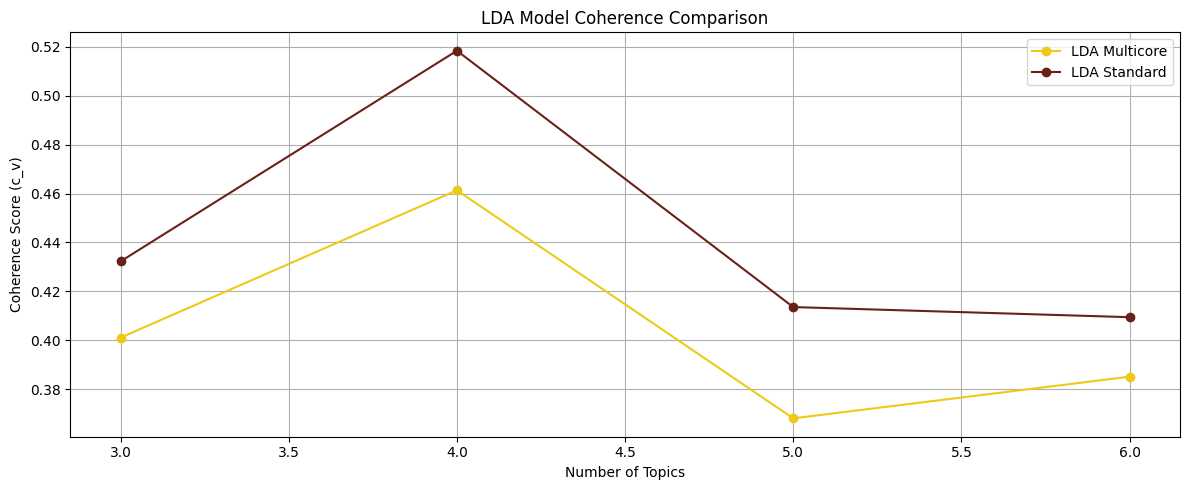

In [18]:
plot_path = LDA_FIGURES_DIR / "lda-coherence-scores-comparison.png"

plot_lda_coherence([
    ("LDA Multicore", coherence_mc),
    ("LDA Standard", coherence_std)
    ],
    figure_path = plot_path
)

After comparing both the standard LDA model and its multicore version, the standard model performed better overall. It achieved a higher coherence score (0.5183 vs. 0.4613), indicating more semantically meaningful and internally consistent topics.

The standard model also produced clearer and more distinct topics, with less overlap among key terms. On the other hand, the multicore model showed some redundancy across topics, suggesting less effective separation.

While the multicore model offers faster training on large datasets, in this case, the standard model provided more coherent and well-defined results. For small to medium-sized corpora where topic quality matters most, the standard LDA remains the more reliable choice.

### Select Final LDA Model

The standard LDA model was selected as the best fit for this project. It was trained with 4 topics, chosen based on its highest coherence score of 0.5183 among the models tested. On the surface, it appears to identify distinct topics and relevant keywords effectively. However, it’s still necessary to evaluate the interpretability of the topics and the overall model to confirm if this is the best choice for topic modeling Fitzgerald’s novels.

In [19]:
# Display best LDA model based on coherence
best_lda_model = best_lda_standard
best_num_topics = topics_std
coherence_values = coherence_std

# Find the best score based on best_num_topics
best_score = dict(coherence_values)[best_num_topics]

# Print summary of the best model
print(f"\nBest LDA Model has {best_lda_model.num_topics} topics with coherence score {best_score:.4f}\n")

# Pretty-print the topics
pprint(best_lda_model.print_topics(num_words = 20))


Best LDA Model has 4 topics with coherence score 0.5183

[(0,
  '0.001*"lawn" + 0.001*"porch" + 0.001*"dog" + 0.001*"camp" + 0.001*"wood" + '
  '0.001*"heat" + 0.001*"kissed" + 0.001*"marry" + 0.001*"lord" + '
  '0.001*"horse" + 0.001*"sick" + 0.001*"oxford" + 0.001*"grey" + 0.001*"song" '
  '+ 0.001*"newspaper" + 0.001*"japanese" + 0.001*"elevator" + 0.001*"son" + '
  '0.001*"pool" + 0.001*"waiter"'),
 (1,
  '0.000*"except" + 0.000*"fold" + 0.000*"luxury" + 0.000*"lavender" + '
  '0.000*"whispering" + 0.000*"arrive" + 0.000*"lap" + 0.000*"blurred" + '
  '0.000*"concern" + 0.000*"enemy" + 0.000*"weep" + 0.000*"anxiously" + '
  '0.000*"possess" + 0.000*"muffled" + 0.000*"invisible" + 0.000*"button" + '
  '0.000*"disappeared" + 0.000*"stout" + 0.000*"whereupon" + 0.000*"queen"'),
 (2,
  '0.000*"artistic" + 0.000*"reward" + 0.000*"discreetly" + 0.000*"possess" + '
  '0.000*"willing" + 0.000*"arrive" + 0.000*"wanting" + 0.000*"dock" + '
  '0.000*"invisible" + 0.000*"grocery" + 0.000*"muff

In [20]:
# Save the metrics of the best lda model
output_path = LDA_METRICS_RESULTS_DIR / "best-lda-model-summary.txt"

with open(output_path, "w", encoding = "utf-8") as f:
    f.write(f"Best LDA Model has {best_lda_model.num_topics} topics with coherence score {best_score:.4f}\n\n")
    for topic_id, topic in best_lda_model.print_topics(num_words=20):
        f.write(f"Topic {topic_id}: {topic}\n")

In [21]:
# Save the trained lda model
lda_model_path = LDA_MODEL_DIR / f"best-lda-model-{best_lda_model.num_topics}-topics.model"
best_lda_model.save(str(lda_model_path))

#### Top Keywords

In [22]:
# Display top keywords
print("== Final LDA Model Topics and Keywords Summary ==\n")
for topic_id in range(best_lda_standard.num_topics):
    words = [word.replace('_', ' ') for word, _ in best_lda_model.show_topic(topic_id, topn = 15)]
    print(f"Topic {topic_id} | {', '.join(words)}")

== Final LDA Model Topics and Keywords Summary ==

Topic 0 | lawn, porch, dog, camp, wood, heat, kissed, marry, lord, horse, sick, oxford, grey, song, newspaper
Topic 1 | except, fold, luxury, lavender, whispering, arrive, lap, blurred, concern, weep, enemy, anxiously, possess, muffled, invisible
Topic 2 | artistic, reward, discreetly, possess, willing, wanting, arrive, dock, invisible, grocery, muffled, except, fierce, discreet, literally
Topic 3 | wire, shirt, murmur, bay, corrected, embarrassed, hardly, goodbye, dock, embarrassment, exercise, fault, newspaper, lawn, vast


#### Document Topic Distribution per Chapter

The topic distribution reveals how much each topic contributes to a document. After training the LDA model, every document is represented as a mixture of topics, each with an associated probability. This helps pinpoint the dominant themes within a document and understand how its content spreads across different topics.

In [23]:
print("== Topic Distribution per Chapter ==")

# Get topic distributions for all documents in the corpus
doc_topics = [best_lda_model.get_document_topics(doc) for doc in corpus_tfidf]

# Print topic distributions
for i, (topics, meta) in enumerate(zip(doc_topics, chapter_metadata), 1):
    book = meta["book"].replace('-', ' ').title()
    chapter = meta["chapter_title"]
    
    print(f"\nDocument {i}:")
    print(f"Book: '{book}' | Chapter: '{chapter}'")
    print("Topic Distribution:")
    for topic_id, prob in topics:
        print(f"  Topic {topic_id}: {prob:.4f}")

== Topic Distribution per Chapter ==

Document 1:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER I'
Topic Distribution:
  Topic 0: 0.9753
  Topic 1: 0.0106

Document 2:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER II'
Topic Distribution:
  Topic 0: 0.9785

Document 3:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER III'
Topic Distribution:
  Topic 0: 0.9732
  Topic 1: 0.0115

Document 4:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER IV'
Topic Distribution:
  Topic 0: 0.9751
  Topic 1: 0.0107

Document 5:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER I'
Topic Distribution:
  Topic 0: 0.9682
  Topic 1: 0.0136
  Topic 2: 0.0101

Document 6:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER II'
Topic Distribution:
  Topic 0: 0.9713
  Topic 1: 0.0123

Document 7:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER III'
Topic Distribution:
  Topic 0: 0.9667
  Topic 1: 0.0142
  Topic 2: 0.0106

Document 8:
Book: 'This Side Of Paradise' | Chapter: 'CHAPTER IV'
Topic Distributio

In [24]:
# Save document topic distribution as text file
topic_dist_path = LDA_DOCUMENTS_RESULTS_DIR / "document-topic-distributions-per-chapter.txt"

with open(topic_dist_path, "w") as f:
    f.write("== Topic Distribution per Chapter ==")
    for i, (topics, meta) in enumerate(zip(doc_topics, chapter_metadata), 1):
        book = meta["book"].replace('-', ' ').title()
        chapter = meta["chapter_title"]
        
        f.write(f"\nDocument {i}:")
        f.write(f"Book: '{book}' | Chapter: '{chapter}'")
        f.write("Topic Distribution:")
        for topic_id, prob in topics:
            f.write(f"  Topic {topic_id}: {prob:.4f}")

As shown in the output and the following graphs, most chapters are dominated by a single topic (Topic 0), with minimal contribution from other topics. This highlights a limitation of the model as it tends to capture a broad, general theme rather than distinguishing distinct chapter-level themes. This may be because the text’s rich vocabulary and complex style are too detailed for a basic model like LDA to capture well.

Since the analysis is performed at the chapter level, using smaller text units isn’t an option. The best way forward would be to try alternative methods like BERTopic, which handle complex texts better and may offer clearer topic separation.

In [25]:
# Store topic probabilities
records = []

for i, (topics, meta) in enumerate(zip(doc_topics, chapter_metadata)):
    row = {
        "book": meta["book"].replace('-', ' ').title(),
        "chapter": meta["chapter_title"],
    }
    
    for topic_id, prob in topics:
        row[f"topic_{topic_id}"] = prob

    records.append(row)

# Create DataFrame and fill missing topic columns with 0
df = pd.DataFrame(records).fillna(0)

# Identify topic columns
topic_cols = [col for col in df.columns if col.startswith("topic_")]

# Add a column for the dominant topic in each chapter
df["dominant_topic"] = df[topic_cols].idxmax(axis = 1)
df["dominant_topic_num"] = df["dominant_topic"].str.extract(r"(\d+)").astype(int)

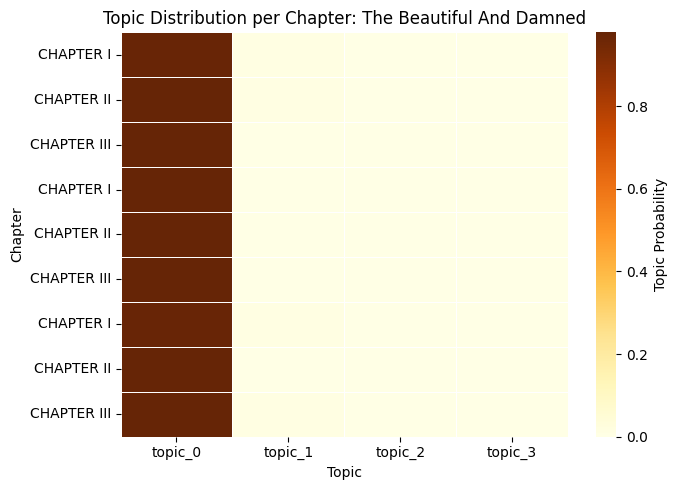

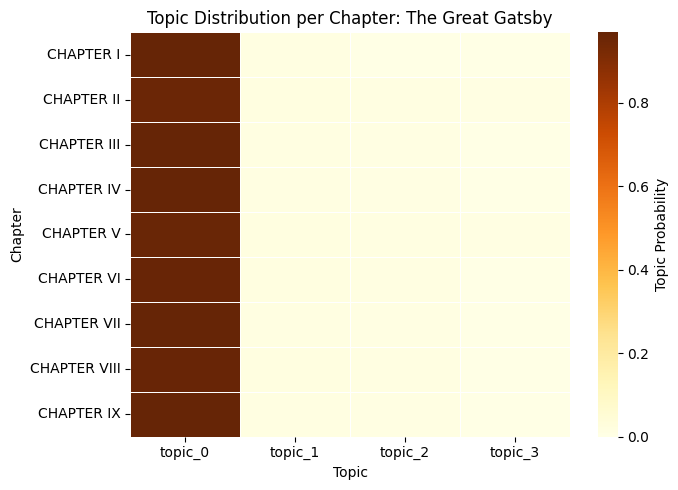

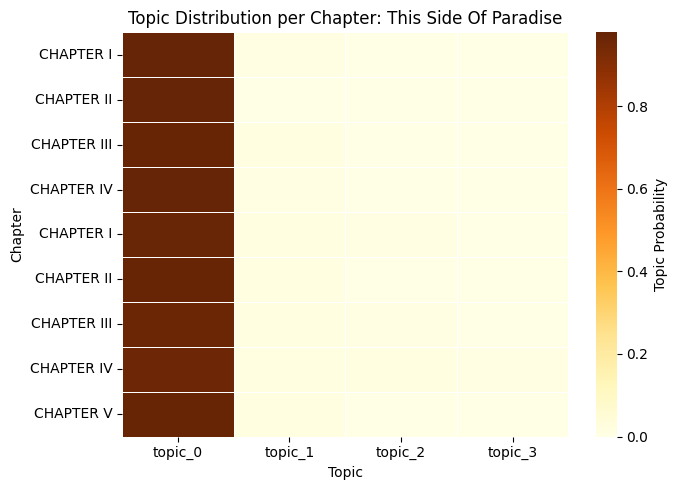

In [26]:
for book_name, group in df.groupby("book"):

    figure_path = LDA_FIGURES_DIR / f"{book_name.replace(' ', '-').lower()}-document-topic-distribution-per-chapter-lda.png"

    group_sorted = group.reset_index(drop = True)

    # Build matrix of topic probabilities
    heat_data = group_sorted[topic_cols]
    heat_data.index = group_sorted["chapter"]

    # Plot heatmap
    plt.figure(figsize = (7, 5))
    ax = sns.heatmap(heat_data, cmap = "YlOrBr", linewidths = 0.5, cbar_kws = {"label": "Topic Probability"})
    plt.title(f"Topic Distribution per Chapter: {book_name}")
    plt.xlabel("Topic")
    plt.ylabel("Chapter")
    plt.tight_layout()
    plt.savefig(figure_path)

### LDA Topic Interpretation

Topic interpretation focuses on making sense of the topics identified by the model. Each topic is made up of keywords that frequently appear together across documents. Interpreting the model involves a few key steps:

- **Top keywords:** A list of the most relevant words for each topic, giving a sense of what the topic is about.
- **Representative documents:** Examples of documents where a topic is most dominant, helping to understand how it appears in context.
- **Manual topic labeling:** Assigning a meaningful label to each topic based on its keywords and representative documents.

In [27]:
def get_topic_keywords(lda_model, num_words = 10):
    """
    Extract the top keywords that define each topic in the LDA model.

    Parameters
    ----------
    lda_model : gensim.models.LdaModel
        A trained LDA model.
    num_words : int, optional
        Number of top words to extract for each topic (default is 10).

    Returns
    -------
    dict
        Dictionary with topic IDs as keys and lists of top keywords as values.
    """
    topic_keywords = {}
    for topic_id in range(lda_model.num_topics):
        topic_keywords[topic_id] = [word for word, _ in lda_model.show_topic(topic_id, topn = num_words)]
    return topic_keywords

In [28]:
def get_topic_representative_docs(lda_model, corpus, texts, topn_docs=3):
    """
    Identify representative documents for each topic based on the topic distribution.

    Parameters
    ----------
    lda_model : gensim.models.LdaModel
        A trained LDA model.
    corpus : list of list of (int, int)
        Bag-of-words representation of the corpus.
    texts : list of str
        List of original or preprocessed document texts
    topn_docs : int, optional
        Number of most representative documents to return per topic (default is 3).

    Returns
    -------
    dict
        Dictionary with topic IDs as keys and lists of (doc_index, topic_probability) tuples as values.
    """
    topic_docs = defaultdict(list)
    for i, bow in enumerate(corpus):
        topic_probs = lda_model.get_document_topics(bow)
        for topic_id, prob in topic_probs:
            topic_docs[topic_id].append((i, prob))

    for topic_id in topic_docs:
        topic_docs[topic_id] = sorted(topic_docs[topic_id], key=lambda x: -x[1])[:topn_docs]

    return topic_docs

In [29]:
def interpret_topics(lda_model, corpus, texts, num_words=10, topn_docs=3, save_path=None):
    """
    Display topic keywords and representative docs, and save them if a directory path is provided.

    Parameters
    ----------
    lda_model : gensim.models.LdaModel
    corpus : list of (int, int)
    texts : list of list of str or str
    num_words : int
    topn_docs : int
    save_path : Path or str or None
        Directory where output files will be saved.
        Saves:
            - lda-model-keywords.json
            - lda-model-topic-interpretation.txt
    """
    topic_keywords = get_topic_keywords(lda_model, num_words)
    topic_docs = get_topic_representative_docs(lda_model, corpus, texts, topn_docs)

    output_lines = []

    for topic_id in range(lda_model.num_topics):
        header = f"\nTopic {topic_id} | {', '.join(topic_keywords[topic_id])}"
        print(header)
        output_lines.append(header)

        print("Representative Documents:")
        output_lines.append("Representative Documents:")

        for doc_index, prob in topic_docs[topic_id]:
            doc_text = texts[doc_index]
            if isinstance(doc_text, list):
                snippet = " ".join(doc_text)[:300].replace("\n", " ")
            else:
                snippet = doc_text[:300].replace("\n", " ")

            line = f"Prob: {prob:.2f} | {snippet}"
            print(line)
            output_lines.append(line)

        print('-' * 40)
        output_lines.append('-' * 40)

    if save_path:
        save_dir = Path(save_path)

        # JSON: topic keywords
        json_path = save_dir / "lda-model-keywords.json"
        with open(json_path, "w", encoding="utf-8") as f_json:
            json.dump(topic_keywords, f_json, indent=2)

        # TXT: full interpretation
        txt_path = save_dir / "lda-model-topic-interpretation.txt"
        with open(txt_path, "w", encoding="utf-8") as f_txt:
            f_txt.write("\n".join(output_lines) + "\n")

In [30]:
# Interpret the topics and save top keywords
results_path = LDA_TOPICS_RESULTS_DIR
print("== Topic Interpretation: Top Keywords and Representative Documents ==")
interpret_topics(best_lda_model, corpus_tfidf, documents, num_words = 10, topn_docs = 3, save_path = results_path)

== Topic Interpretation: Top Keywords and Representative Documents ==

Topic 0 | lawn, porch, dog, camp, wood, heat, kissed, marry, lord, horse
Representative Documents:
Prob: 0.98 | symposium lulled mind sleep wisest finest hung brilliant curtain doorway shutting sun believed bore invariably stamp sun pattern curtain lassitude brought summer golden enervating spring loitered restive lazily extravagant california coast joining party intermittently drifting pasadena coronado coro
Prob: 0.98 | connoisseur kiss undergraduate editor crimson desired senior picked glorified illusion aside service accomplish vague yearnful react eternal reward least personal satisfaction striven greatest greatest number spirit rocked america begin rule immaturity facile impression yearsometimes preparatory pro
Prob: 0.98 | radiant fortnight indulge practical discussion session guise severe realism eternal moonlight critic belleslettres insist loved protested stand sandwich informing passersby reason marry jun

The results show that the current LDA model struggles to identify clear, coherent topics. Low and similar topic probabilities, overlapping keywords, and repeated representative documents suggest weak topic separation.

This is likely due not just to model settings, but to the nature of the text. Fitzgerald’s rich, symbolic language and layered themes challenge LDA’s assumptions, which rely on straightforward word-topic patterns. The model’s simplicity limits its ability to capture this complexity.

To get more meaningful results, advanced methods like contextual embeddings (e.g., BERTopic) or hierarchical models, combined with better preprocessing, should be explored. These results highlight the need for more tailored approaches when modeling literary texts.

### **Conclusion on LDA Topic Modeling of Fitzgerald’s Novels**

Latent Dirichlet Allocation (LDA) was used to explore thematic structures in Fitzgerald’s novels through iterative modeling, detailed preprocessing, and coherence-based evaluation.

**What happened:**

- Early models with 3–4 topics showed moderate coherence (\~0.43–0.59), improving with better vocabulary filtering.
- The best model reached a coherence score of **0.6570** with 5 topics.
- One topic consistently stood out—centered on vivid, outdoor and romantic imagery.
- However, most other topics were vague, overlapping, and lacked clear thematic focus.
- Repeated top documents across topics pointed to redundancy and limited topic separation, likely due to Fitzgerald’s poetic and stylistic language.

**Why LDA Falls Short:**

Fitzgerald’s writing is rich in metaphor, abstraction, and lyrical style that challenge LDA’s bag-of-words assumptions. As a result:

- LDA struggles to separate subtle, overlapping themes.
- Some topics appear as loosely connected clusters of general or abstract terms, lacking clear meaning.
- Significant document overlap across topics suggests poor thematic separation.

**Next Steps:**

To overcome LDA’s limitations, BERTopic is a strong next step. It uses contextual embeddings (e.g., BERT) to capture nuanced themes and semantic relationships that LDA misses. By clustering in semantic space, it provides clearer, more meaningful topics—especially useful for literary texts like Fitzgerald’s. BERTopic also supports dynamic topic modeling and intuitive visualizations, making it well-suited for chapter-based analysis.